# setup

In [2]:
%cd /workspace
%load_ext autoreload
%autoreload 2

/workspace


In [171]:
experiment_type = 'edit' #@param ['edit', 'free_generation']

description = 'Man with a beard' #@param {type:"string"}

latent_path = None #@param {type:"string"}

optimization_steps = 300 #@param {type:"number"}

l2_lambda = 0.008 #@param {type:"number"}

id_lambda = 0.005 #@param {type:"number"}

stylespace = False #@param {type:"boolean"}

create_video = True #@param {type:"boolean"}

In [172]:
use_seed = True #@param {type:"boolean"}

seed = 1 #@param {type: "number"}

### Encoding image into Style Space

In [5]:
from src.models.e4e import pSp

In [6]:
from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms


EXPERIMENT_ARGS = {
        "model_path": "saved/models/e4e_ffhq_encode.pt"
    }
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading e4e over the pSp framework from checkpoint: saved/models/e4e_ffhq_encode.pt
Model successfully loaded!


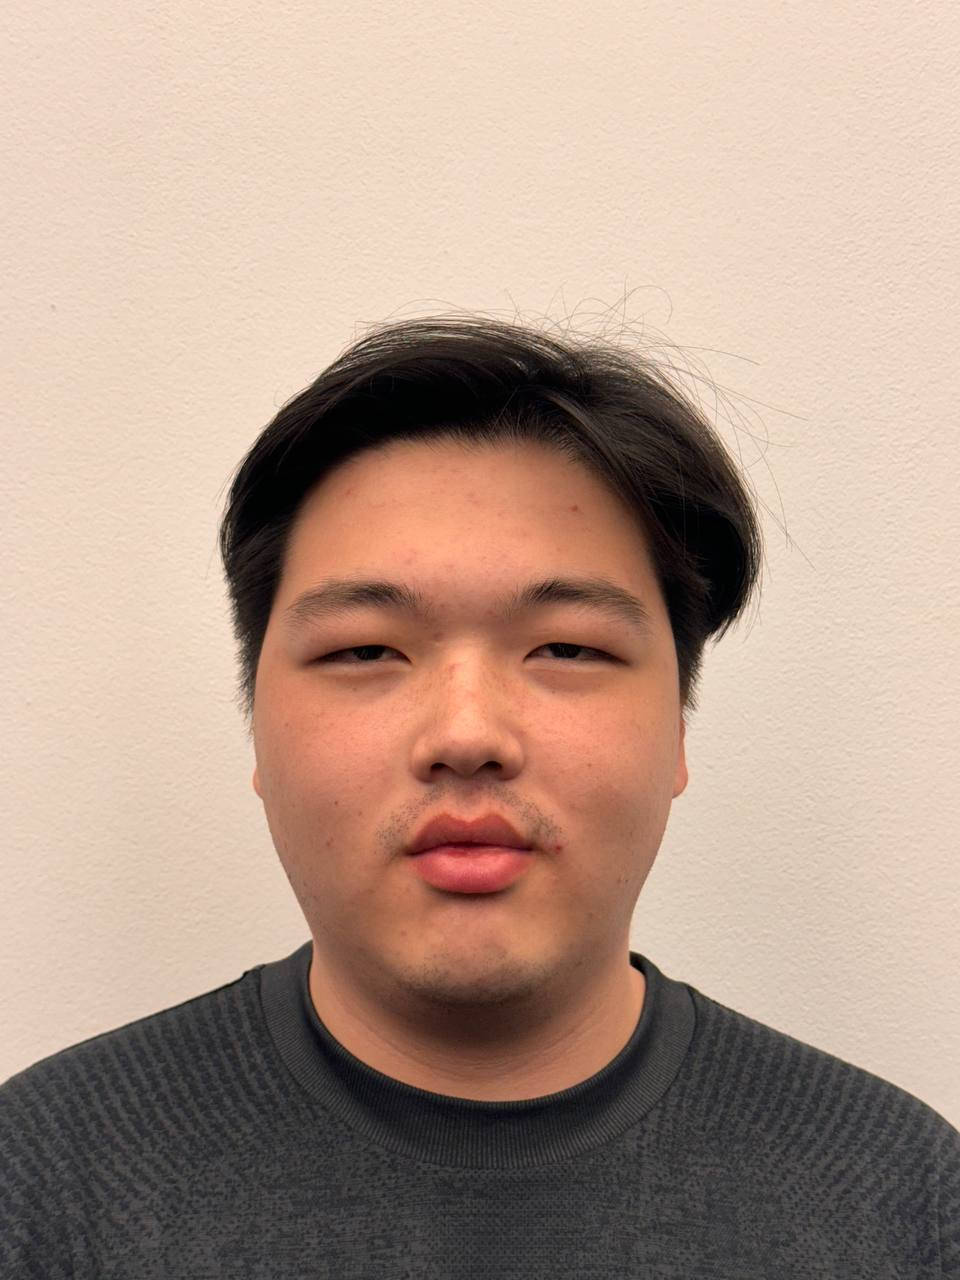

In [176]:
from PIL import Image

img = Image.open('/workspace/data/dias.jpg')
img

In [177]:
import dlib
from src.models.e4e.utils import align_face


def run_alignment(image_path):
    predictor = dlib.shape_predictor("saved/shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor) 
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image 


img = run_alignment('data/dias.jpg')
tensor_img = EXPERIMENT_ARGS['transform'](img)

Aligned image has shape: (256, 256)


In [178]:
decoded, latent, style_vector = net(tensor_img.unsqueeze(0).cuda(), randomize_noise=False, return_latents=True)
decoded.shape, latent.shape, style_vector.__len__()

(torch.Size([1, 3, 256, 256]), torch.Size([1, 18, 512]), 26)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


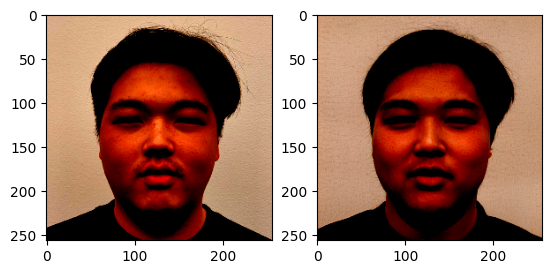

In [179]:
_, axs = plt.subplots(ncols=2)
axs[0].imshow(tensor_img.squeeze().permute(1, 2, 0))
axs[1].imshow(decoded.squeeze().permute(1, 2, 0).detach().cpu())

In [180]:
torch.save(latent, 'data/dias_latent.pt')

## Editing baha

In [181]:
args = {
    "description": description,
    "ckpt": "saved/stylegan2/stylegan2-ffhq-config-f.pt",
    "stylegan_size": 1024,
    "lr_rampup": 0.05,
    "lr": 0.1,
    "step": optimization_steps,
    "mode": experiment_type,
    "l2_lambda": l2_lambda,
    "id_lambda": id_lambda,
    'work_in_stylespace': stylespace,
    "latent_path": 'data/dias_latent.pt',
    "truncation": 0.7,
    "save_intermediate_image_every": 1 if create_video else 20,
    "results_dir": "saved/results",
    "ir_se50_weights": "saved/models/model_ir_se50.pth"
}

In [182]:
if use_seed:
    import torch
    torch.manual_seed(seed)


from src.models.styleclip.optimization import optimize
from argparse import Namespace

result = optimize(Namespace(**args))

Loading ResNet ArcFace


loss: 0.7412;: 100%|██████████| 300/300 [00:49<00:00,  6.02it/s]


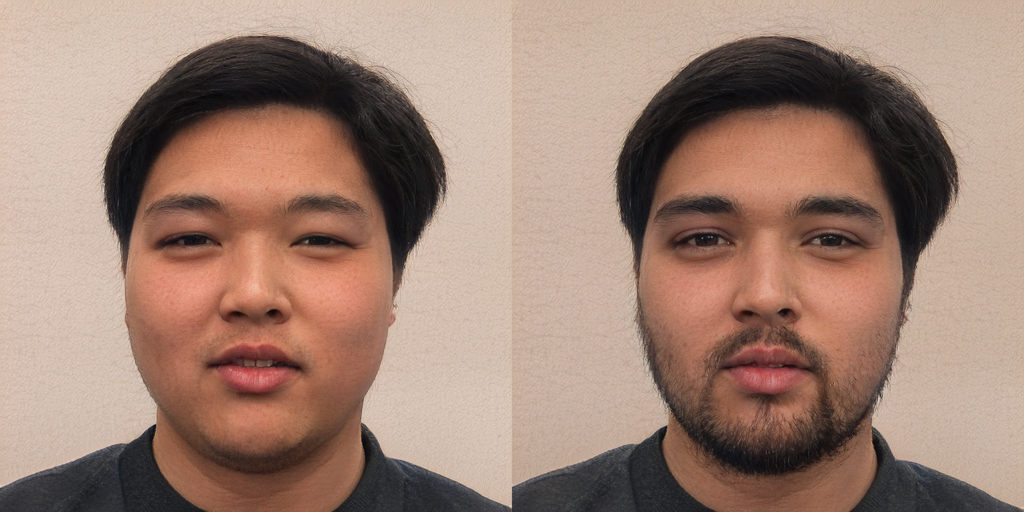

In [183]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage


result_image = ToPILImage()(make_grid(result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))